In [1]:
import myLineComponents as L
import myImageProcessing as I
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import numpy as np

% matplotlib inline

In [2]:
def process_image(lane_img):
    
    lane_dst = cv2.undistort(lane_img, I.mtx, I.dist, None, I.mtx)
    
    # diag2
    lane_thresholded = I.thresholding(lane_dst)
    
    # diag3
    lane_warped = I.warping(lane_thresholded)
    
    # diag4
    lane_slidingwindowed = I.sliding_window_method(lane_warped)
    
    lx,rx,ly,ry,lfx,rfx,lc,rc,lr2,rr2,oc= I.findCurvature(lane_slidingwindowed)
    info = {'lc':lc, 'rc': rc, 'lr2':lr2, 'rr2': rr2, 'oc': oc}
    
    # diag5
    lane_detected = I.drawCurves(lx, rx, ly, ry, lfx, rfx)

    # diag1 
    lane_unwarped = I.unwarping(lane_dst, lane_slidingwindowed)

    # assemble diagnostic screens
    diagScreen = I.createDiagScreen(lane_unwarped, lane_thresholded, 
                                  lane_warped, lane_slidingwindowed*255,
                                  lane_detected, info)
    return diagScreen

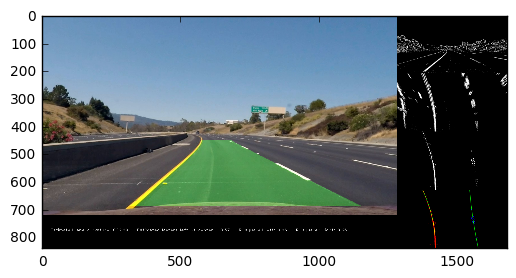

In [4]:
plt.imshow(process_image(mpimg.imread(os.path.join('./project_video_frames', '12_25_32_532314.jpeg'))))

In [7]:
# This cell was run last after all the necessary fixes made to the original processing methods. 

lane_images = glob.glob('./project_video_frames/*.jpeg')

if not os.path.exists('./diag/'):
    os.makedirs('./diag/')

for s in lane_images:   
    result = process_image(mpimg.imread(s))
    mpimg.imsave('./diag/'+s[-20:], result)

In [4]:
# Choose five bad examples.

bad = sorted(['12_26_15_521921.jpeg', '12_26_51_657416.jpeg', '12_26_22_236967.jpeg',
       '12_26_41_714197.jpeg', '12_27_05_399166.jpeg'])

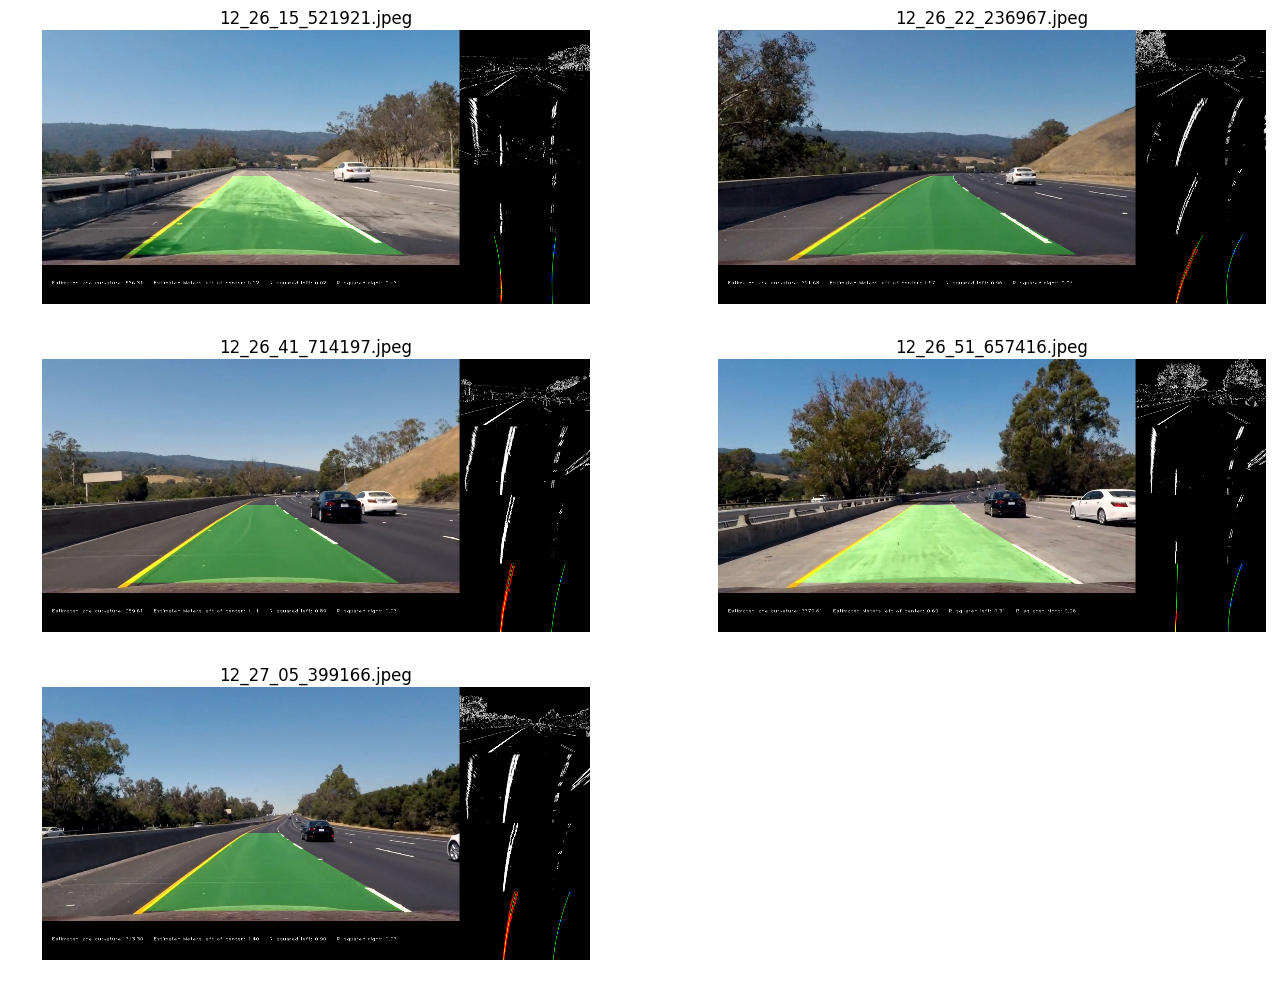

In [4]:
fig = plt.figure()
fig.set_figwidth(16); fig.set_figheight(12)

for n, b in enumerate(bad): 
    file = os.path.join('./project_video_frames', b)
    
    ax = fig.add_subplot(3,2,n+1, title=b)
    ax.axis('off')
    lane_img = mpimg.imread(file)
    result = process_image(lane_img)

    ax = plt.imshow(result)

These problematic detections are caused by incorrect sliding windows. Let me take a deeper dive. 

## Solutions:

1). Updated my way of identifying lane lines by looking for peaked wavelets rather than pinnacles. This fixed the last two bad examples.  
`
New:
mid_left_start = signal.find_peaks_cwt(histogram[:int(w/2)], np.arange(50,100))[-1]
mid_right_start = signal.find_peaks_cwt(histogram[int(w/2):], np.arange(50,100))[0]+int(w/2)
Old: 
mid_left_start = np.clip(np.argmax(histogram[:int(w/2)]),1,640)
mid_right_start = np.clip(np.argmax(histogram[int(w/2):])+int(w/2),640,1279)
`

In [7]:
plt.imshow(process_image(mpimg.imread(os.path.join('./project_video_frames', bad[4]))))

/Users/tz/anaconda/envs/carnd-term1/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/tz/anaconda/envs/carnd-term1/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/tz/anaconda/envs/carnd-term1/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


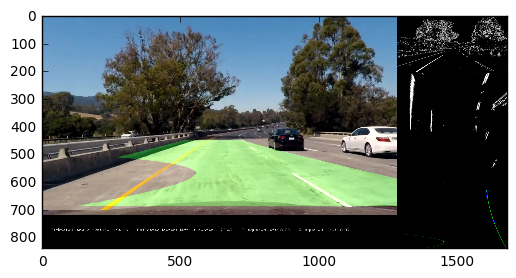

In [6]:
plt.imshow(process_image(mpimg.imread(os.path.join('./project_video_frames', bad[3]))))

## Solutions: 

2). Updated wavelet width from 10 to 30 to 50 to 100. Avoid considering wavelets that are just flat, with a histogram value of less than 100. 

/Users/tz/anaconda/envs/carnd-term1/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/tz/anaconda/envs/carnd-term1/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/tz/anaconda/envs/carnd-term1/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


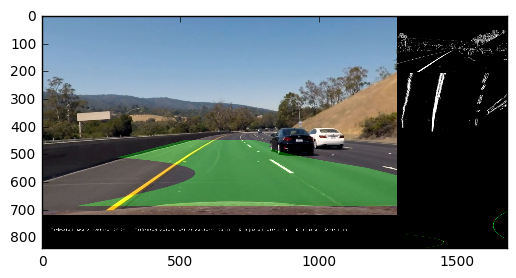

In [7]:
plt.imshow(process_image(mpimg.imread(os.path.join('./project_video_frames', bad[2]))))

In [8]:
plt.imshow(process_image(mpimg.imread(os.path.join('./project_video_frames', bad[1]))))

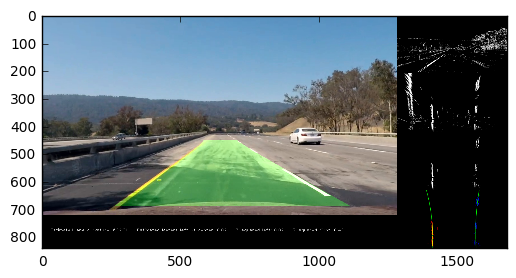

In [9]:
plt.imshow(process_image(mpimg.imread(os.path.join('./project_video_frames', bad[0]))))

## Solution:

3). Further diagnosis. If left and right starting midpoints are off, the lanes are likely to be wrong. The solution will have to come in the actual streaming where previous frames' information can be passed on. If given the right left and right starting point, and the lanes are still plotted incorrectly, I may want to look at the variance in a sliding window. It turned out that the variance really helped. I have much fewer problematic frames now. I will move on to the next stage of the project where I will work on the video. 

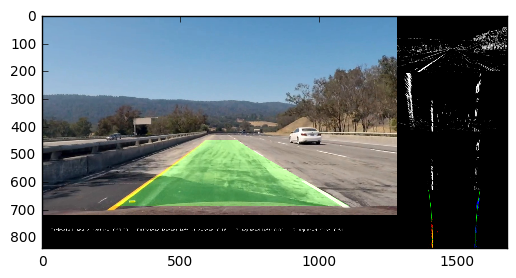

In [10]:
h,w,c=720,1280,3
plt.imshow(process_image(mpimg.imread(os.path.join('./project_video_frames', '12_26_15_675322.jpeg'))))

In [77]:
bad = ['12_26_17_793889.jpeg', '12_26_17_715519.jpeg','12_26_17_250185.jpeg', 
       '12_26_17_871551.jpeg', '12_26_20_038457.jpeg', '12_26_17_946710.jpeg',
       '12_26_18_335707.jpeg', '12_26_15_367005.jpeg', '12_26_15_754623.jpeg']

In [78]:
fig = plt.figure()
fig.set_figwidth(16); fig.set_figheight(24)

for n, b in enumerate(bad): 
    file = os.path.join('./project_video_frames', b)
    
    ax = fig.add_subplot(5,2,n+1, title=b)
    ax.axis('off')
    lane_img = mpimg.imread(file)
    result = process_image(lane_img)

    ax = plt.imshow(result)

In [15]:
from scipy import signal
y_arr = np.linspace(0, h, num = h+1) # array([0., 1., 2., ..., 720.])

In [72]:
def sliding_window_method(warped, δh=64, δv=72):
    '''
    `warped`: perspective transformed image.
    `δh`: the width of the sliding window divided by 2.
    `δv`: the height of the sliding window.
    
    '''
    
    histogram = np.sum(warped[int(warped.shape[0]/2):, :], axis=0)
    
    # Find the centers of the first two sliding windows. 
    mlx, mrx = I.find_lane_start(histogram)
    
    '''
    If I just update left mid start point to the correct value, the lanes are detected 
    correclty! 
    
    '''
    mrx = 900
    # Let y be 720. As the sliding windows travel upward, y decreases. 
    y = h
    
    # Create a blank image. 
    lane_pts = np.zeros_like(warped)

    while y > 0:
        # Zoom into the left and right sliding windows. 
        # Clip them using the left, center, and right vertical lines. 
        bbox_left = warped[(y-δv):y, np.clip((mlx-δh),1,639):np.clip((mlx+δh),1,639)]
        bbox_right = warped[(y-δv):y, np.clip((mrx-δh),640,1279):np.clip((mrx+δh),640,1279)]
        print(np.std(np.sum(bbox_left, axis=0)))
        print(np.std(np.sum(bbox_right, axis=0)))
        
        # Update `lane_pts` based on sliding windows, where pixel values=255.  
        lane_pts[(y-δv):y, np.clip((mlx-δh),1,639):np.clip((mlx+δh),1,639)][(bbox_left==255)] = 1
        lane_pts[(y-δv):y, np.clip((mrx-δh),640,1279):np.clip((mrx+δh),640,1279)][(bbox_right==255)] = 1
        
        # Use new histogram to find lane lines, where there is the highest
        # concentration of pixels. 
        hist_left = np.sum(bbox_left, axis=0)
        hist_right = np.sum(bbox_right, axis=0)
        
        # Define peaks to have a width between 60 and 100 pixels. 
        peakind_left = signal.find_peaks_cwt(hist_left, np.arange(50,100))
        peakind_right = signal.find_peaks_cwt(hist_right, np.arange(50,100))

        
        # If peaks are found, update sliding window centers. 
        # Choose peaks are closer to the center of the image. 
        if len(peakind_left)>0 and np.std(np.sum(bbox_left, axis=0)) >1000:
            mlx = int(np.clip(peakind_left[-1]+mlx-δh,0,w/2))

        if len(peakind_right)>0 and np.std(np.sum(bbox_right, axis=0)) > 1000:
            mrx = int(np.clip(peakind_right[0]+mrx-δh,w/2,w))

        # Shift sliding window upward until it hits the top of the image. 
        y -= δv
        
    return lane_pts

In [73]:
lane_img = mpimg.imread(os.path.join('./project_video_frames', '12_26_17_095371.jpeg')) # '12_26_15_367005.jpeg

lane_dst = cv2.undistort(lane_img, I.mtx, I.dist, None, I.mtx)

# diag2
lane_thresholded = I.thresholding(lane_dst)

# diag3
lane_warped = I.warping(lane_thresholded)

# diag4
lane_slidingwindowed = sliding_window_method(lane_warped)

lx,rx,ly,ry,lfx,rfx,lc,rc,lr2,rr2,oc= I.findCurvature(lane_slidingwindowed)
info = {'lc':lc, 'rc': rc, 'lr2':lr2, 'rr2': rr2, 'oc': oc}

# diag5
lane_detected = I.drawCurves(lx, rx, ly, ry, lfx, rfx)

5187.74608958
1373.59476347
5014.08383465
3691.05709037
4346.26250621
690.928614682
2673.83490284
426.56125565
0.0
2911.42088528
0.0
4068.00062677
0.0
0.0
0.0
1145.36494932
0.0
6753.7739982
0.0
3070.14748713


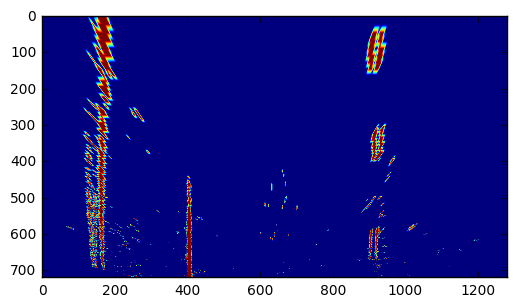

In [74]:
plt.imshow(lane_warped)

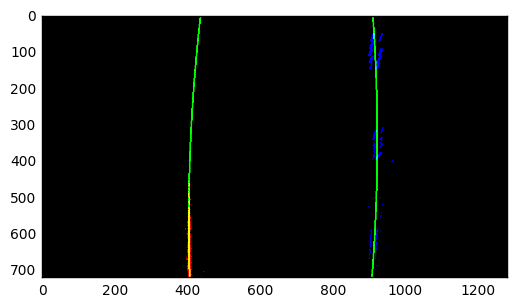

In [75]:
plt.imshow(lane_detected*255)

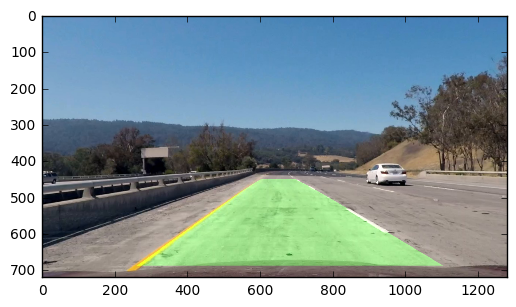

In [76]:
plt.imshow(I.unwarping(lane_dst, lane_slidingwindowed))